In [35]:
#!pip install plotly
#!pip install seaborn
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_log_error
from scipy.stats import randint
import matplotlib.pyplot as plt
import plotly.express as px, seaborn as sns
sns.set_style('darkgrid')
import datetime

RANDOM_STATE = 42

# <p style="padding:5px; background-color:grey; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 5px 5px">Baseline analysis</p>

In [36]:
training_df = pd.read_csv("dataset/train.csv")
training_df = training_df.sample(frac=0.50, random_state=RANDOM_STATE).reset_index(drop=True)
training_df

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,372605,52.0,Female,5538.0,Married,NaN,Master's,Employed,8.093145,Rural,...,0.0,18.0,497.0,3.0,2020-02-10 15:21:39.274993,Average,No,Weekly,Apartment,2742.0
1,551204,60.0,Female,39711.0,Married,4.0,Bachelor's,Employed,NaN,Suburban,...,0.0,3.0,340.0,3.0,2020-10-16 15:21:39.097737,Poor,No,Weekly,Apartment,1347.0
2,240320,58.0,Female,2364.0,Married,2.0,Bachelor's,NaN,34.452482,Urban,...,2.0,19.0,NaN,7.0,2021-01-02 15:21:39.126661,Poor,No,Monthly,House,2196.0
3,1047361,39.0,Male,9094.0,Divorced,0.0,Bachelor's,NaN,26.241661,Rural,...,1.0,17.0,761.0,5.0,2022-05-11 15:21:39.134960,Poor,Yes,Rarely,Condo,684.0
4,555362,47.0,Male,43189.0,Divorced,NaN,PhD,NaN,26.691921,Suburban,...,1.0,4.0,319.0,4.0,2020-07-28 15:21:39.181605,Poor,Yes,Weekly,Apartment,1714.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,315242,37.0,Female,43912.0,Single,3.0,Bachelor's,Employed,31.641040,Urban,...,1.0,4.0,562.0,2.0,2021-10-17 15:21:39.273973,Average,No,Daily,Apartment,2316.0
599996,62104,23.0,Female,25776.0,Married,4.0,Master's,Employed,26.088895,Urban,...,1.0,2.0,805.0,3.0,2020-08-20 15:21:39.134960,Average,Yes,Monthly,House,1115.0
599997,1089479,29.0,Male,18120.0,Single,4.0,Master's,NaN,36.845257,Rural,...,1.0,8.0,781.0,5.0,2022-02-23 15:21:39.251142,Poor,No,Daily,Condo,29.0
599998,848244,25.0,Female,64861.0,Married,4.0,High School,Employed,37.898628,Suburban,...,0.0,8.0,309.0,6.0,2021-10-05 15:21:39.263607,Average,Yes,Monthly,Apartment,979.0


In [38]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    600000 non-null  int64  
 1   Age                   590637 non-null  float64
 2   Gender                600000 non-null  object 
 3   Annual Income         577640 non-null  float64
 4   Marital Status        590729 non-null  object 
 5   Number of Dependents  545268 non-null  float64
 6   Education Level       600000 non-null  object 
 7   Occupation            420957 non-null  object 
 8   Health Score          562937 non-null  float64
 9   Location              600000 non-null  object 
 10  Policy Type           600000 non-null  object 
 11  Previous Claims       417869 non-null  float64
 12  Vehicle Age           599997 non-null  float64
 13  Credit Score          531158 non-null  float64
 14  Insurance Duration    599999 non-null  float64
 15  

In [39]:
#training_df.isna().sum()
missing = training_df.isna().sum().sort_values(ascending = False)
missing = pd.DataFrame(missing)
missing = missing.rename(columns= {0:'Missing'})
missing.style.background_gradient(cmap='YlOrRd')

,Missing
Previous Claims,182131
Occupation,179043
Credit Score,68842
Number of Dependents,54732
Customer Feedback,39044
Health Score,37063
Annual Income,22360
Age,9363
Marital Status,9271
Vehicle Age,3


In [40]:
training_df.shape

(600000, 21)

In [42]:
max_date = datetime.datetime.strptime(training_df['Policy Start Date'].max(), "%Y-%m-%d %H:%M:%S.%f")
training_df['Policy held days'] = abs(training_df['Policy Start Date'].apply(lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")-max_date).days))
training_df.drop(labels=['Policy Start Date'], axis=1, inplace=True)

In [43]:
num_features = ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Policy held days']
cat_features = ['Policy Type', 'Property Type', 'Gender', 'Exercise Frequency', 'Customer Feedback', 'Smoking Status', 'Education Level', 'Marital Status', 'Occupation', 'Location']

In [44]:
#fill missing numerial with median
training_df[num_features] = training_df[num_features].fillna(training_df[num_features].median())

In [45]:
#categorial feature encoding
cat_encoder = OneHotEncoder(handle_unknown='ignore')#test with dummy an and most frequent fill
cat_encoded_data = cat_encoder.fit_transform(training_df[cat_features]).toarray()
encoded_df = pd.DataFrame(cat_encoded_data, columns=cat_encoder.get_feature_names_out(cat_features))

In [46]:
#normalize numerical data
scaler = preprocessing.RobustScaler()
scaler.fit(training_df[num_features])
num_normalized = scaler.transform(training_df[num_features])
num_normalized = pd.DataFrame(num_normalized, columns = num_features)
num_normalized


,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy held days
0,0.478261,-0.519338,0.0,-0.955522,-1.0,0.8,-0.439462,-0.50,0.818486
1,0.826087,0.447661,1.0,0.000000,-1.0,-0.7,-1.143498,-0.50,0.541203
2,0.739130,-0.609153,0.0,0.574317,1.0,0.9,0.000000,0.50,0.454343
3,-0.086957,-0.418713,-1.0,0.097779,0.0,0.7,0.744395,0.00,-0.095768
4,0.260870,0.546078,0.0,0.123911,0.0,-0.6,-1.237668,-0.25,0.630290
...,...,...,...,...,...,...,...,...,...
599995,-0.173913,0.566537,0.5,0.411147,0.0,-0.6,-0.147982,-0.75,0.133630
599996,-0.782609,0.053340,1.0,0.088913,0.0,-0.8,0.941704,-0.50,0.604677
599997,-0.521739,-0.163303,1.0,0.713188,0.0,-0.2,0.834081,0.00,-0.010022
599998,-0.695652,1.159334,1.0,0.774324,-1.0,-0.2,-1.282511,0.25,0.146993


In [47]:
training_df_filled_norm = pd.concat([training_df[['id','Premium Amount']], num_normalized, encoded_df], axis=1)
label = training_df_filled_norm.pop('Premium Amount')
training_df_filled_norm.set_index('id', inplace=True)

In [48]:
training_df_filled_norm.isna().sum()

Age                            0
Annual Income                  0
Number of Dependents           0
Health Score                   0
Previous Claims                0
Vehicle Age                    0
Credit Score                   0
Insurance Duration             0
Policy held days               0
Policy Type_Basic              0
Policy Type_Comprehensive      0
Policy Type_Premium            0
Property Type_Apartment        0
Property Type_Condo            0
Property Type_House            0
Gender_Female                  0
Gender_Male                    0
Exercise Frequency_Daily       0
Exercise Frequency_Monthly     0
Exercise Frequency_Rarely      0
Exercise Frequency_Weekly      0
Customer Feedback_Average      0
Customer Feedback_Good         0
Customer Feedback_Poor         0
Customer Feedback_nan          0
Smoking Status_No              0
Smoking Status_Yes             0
Education Level_Bachelor's     0
Education Level_High School    0
Education Level_Master's       0
Education 

In [49]:
training_df_filled_norm.shape

(600000, 42)

In [51]:
X_train, X_val, y_train, y_val = train_test_split(training_df_filled_norm, label, train_size = 0.8, random_state = RANDOM_STATE)

# Hyperparameter tuning
param_dist = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'max_depth': randint(1, int(training_df_filled_norm.shape[1]/2)),
    'n_estimators': randint(50, 500),
    'min_child_weight': randint(1, 15),
    'subsample' : [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

xgb = XGBRegressor(objective = 'reg:squarederror',random_state=RANDOM_STATE, early_stopping_rounds = 20)
random_search = RandomizedSearchCV(xgb, param_dist, cv=5, n_iter=25)
random_search.fit(X_train, y_train, eval_set = [(X_val,y_val)], verbose=False)

best_params = random_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'learning_rate': 0.01, 'max_depth': 12, 'min_child_weight': 8, 'n_estimators': 413, 'subsample': 0.5}


In [52]:
xgb_model = XGBRegressor(objective = 'reg:squarederror', random_state = RANDOM_STATE, **best_params)
scores = cross_val_score(xgb_model, training_df_filled_norm, label, cv=5)
print(f"Cross validate accuracy{', '.join([str(s) for s in scores])}")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Cross validate accuracy0.056956050301314565, 0.057541279313894744, 0.05887907254082947, 0.05689321433177952, 0.055928141785668406
0.06 accuracy with a standard deviation of 0.00


Number of epochs 413


/home/saheed/micromamba/envs/ml_scripts/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics validation:
	RMSE: 835.9150


/home/saheed/micromamba/envs/ml_scripts/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics train:
	RMSE: 775.7098
Metrics validation:
	R2: 0.0589
Metrics train:
	R2: 0.1973
Metrics validation:
	RMSLE: 1.1376
Metrics train:
	RMSLE: 1.0942


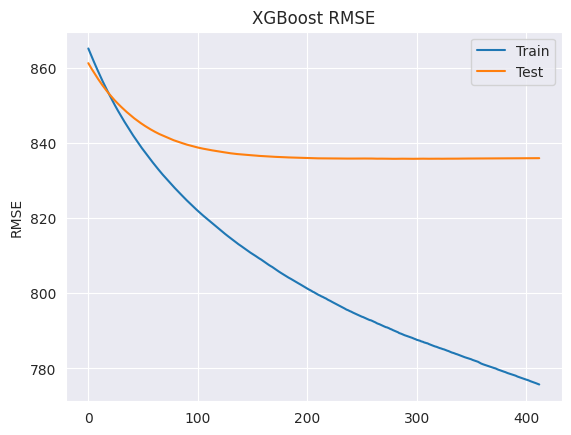

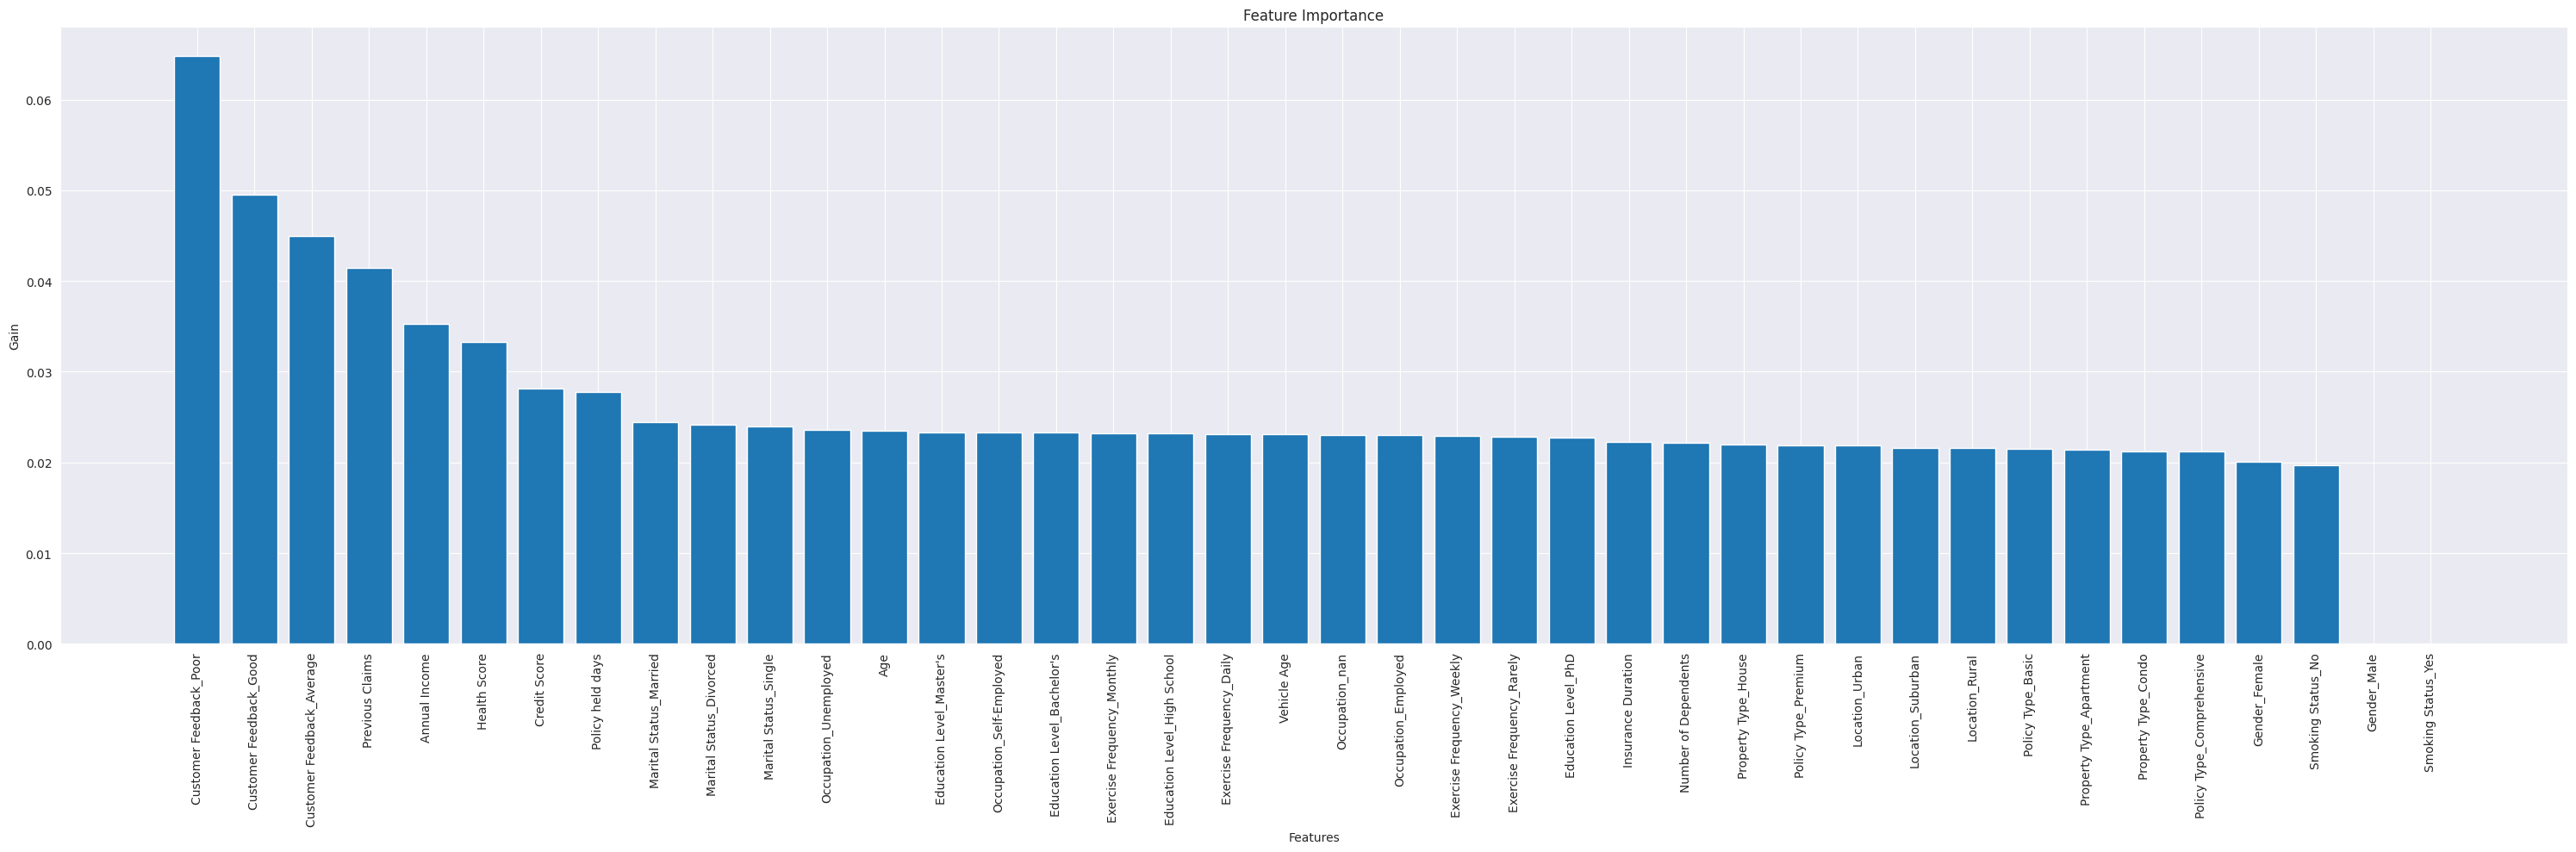

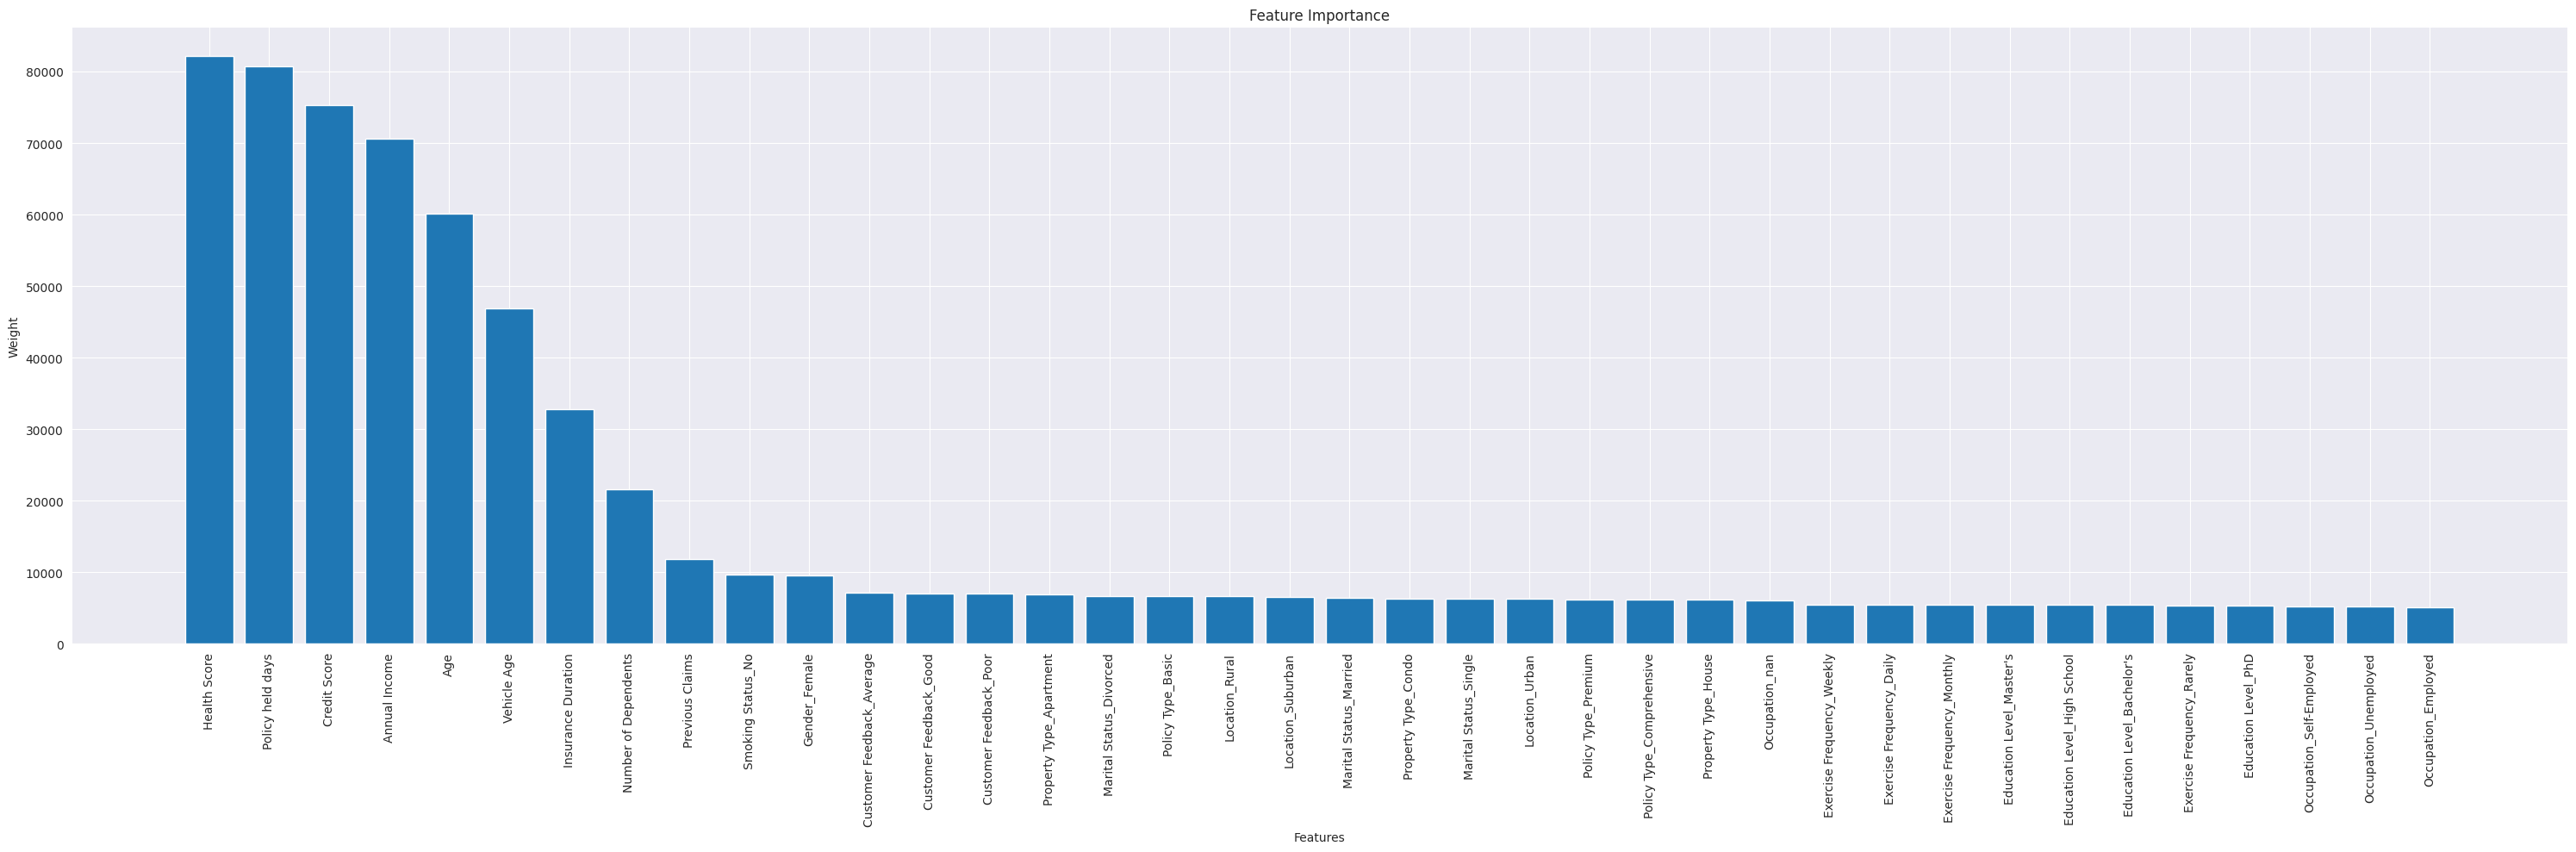

In [53]:
xgb_model.fit(X_train,y_train, eval_set = [(X_train,y_train),(X_val,y_val)], verbose=False)

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
print(f"Number of epochs {epochs}")


# plot log loss
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.savefig("Training_rmsle_50_iter.svg")


# Plot normalized gain
gain = dict(zip(X_train.columns, xgb_model.feature_importances_))
gain = dict(sorted(gain.items(), key=lambda item: item[1], reverse=True))
fig, ax = plt.subplots()
plt.bar(gain.keys(), gain.values())
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Gain')
plt.title('Feature Importance')
fig.set_size_inches(30, 10)
plt.tight_layout()
plt.savefig("Importance_normalized_gain_50_iter_2.svg")
pd.DataFrame.from_dict(gain,orient='index').to_csv("Gain.csv")

# Plot weight
weight = xgb_model.get_booster().get_score(importance_type= "weight")
weight = dict(sorted(weight.items(), key=lambda item: item[1], reverse=True))
fig, ax = plt.subplots()
plt.bar(weight.keys(), weight.values())
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Weight')
plt.title('Feature Importance')
fig.set_size_inches(30, 10)
plt.tight_layout()
plt.savefig("Importance_weight_50_iter_2.svg")
pd.DataFrame.from_dict(weight,orient='index').to_csv("weight.csv")

print(f"Metrics validation:\n\tRMSE: {mean_squared_error(y_val,xgb_model.predict(X_val), squared=False):.4f}")
print(f"Metrics train:\n\tRMSE: {mean_squared_error(y_train,xgb_model.predict(X_train), squared=False):.4f}")
print(f"Metrics validation:\n\tR2: {r2_score(y_val,xgb_model.predict(X_val)):.4f}")
print(f"Metrics train:\n\tR2: {r2_score(y_train,xgb_model.predict(X_train)):.4f}")
print(f"Metrics validation:\n\tRMSLE: {root_mean_squared_log_error(y_val,xgb_model.predict(X_val)):.4f}")
print(f"Metrics train:\n\tRMSLE: {root_mean_squared_log_error(y_train,xgb_model.predict(X_train)):.4f}")

In [54]:
test_df = pd.read_csv("dataset/test.csv")
test_df.shape

(800000, 20)

In [59]:
test_df.isna().sum()

id                           0
Age                          0
Gender                       0
Annual Income                0
Marital Status           12336
Number of Dependents         0
Education Level              0
Occupation              239125
Health Score                 0
Location                     0
Policy Type                  0
Previous Claims              0
Vehicle Age                  0
Credit Score                 0
Insurance Duration           0
Customer Feedback        52276
Smoking Status               0
Exercise Frequency           0
Property Type                0
Policy held days             0
Policy held months           0
Policy held years            0
dtype: int64

In [56]:
max_date = datetime.datetime.strptime(test_df['Policy Start Date'].max(), "%Y-%m-%d %H:%M:%S.%f")
test_df['Policy held days'] = abs(test_df['Policy Start Date'].apply(lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")-max_date).days))
test_df['Policy held months'] = abs(test_df['Policy Start Date'].apply(lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")-max_date).days))/30
test_df['Policy year'] = test_df['Policy Start Date'].apply(lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f").year))
test_df['Policy held years'] = abs(test_df['Policy year']-max_date.year)
test_df.drop(labels=['Policy Start Date','Policy year'], axis=1, inplace=True)


In [60]:
#fill missing numerial with median
test_df[num_features] = test_df[num_features].fillna(test_df[num_features].median())

In [61]:
#normalize numerical data
num_normalized_test = scaler.transform(test_df[num_features])
num_normalized_test = pd.DataFrame(num_normalized_test, columns = num_features)
num_normalized_test

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy held days
0,-0.565217,-0.610681,1.0,-0.980778,0.0,0.9,0.000000,-1.00,-0.528953
1,-0.434783,2.890271,0.0,-0.648604,0.0,0.4,-1.000000,0.75,-0.888641
2,0.260870,-0.192392,-1.0,-0.011746,0.0,0.6,1.004484,1.00,-0.462138
3,-0.565217,0.184865,0.5,-1.127135,0.0,-0.7,0.784753,0.00,-0.688196
4,-0.739130,-0.368655,0.0,-0.737821,0.0,0.4,0.717489,0.50,0.089087
...,...,...,...,...,...,...,...,...,...
799995,0.391304,0.421373,-0.5,-0.583761,0.0,-0.2,-1.282511,-0.75,0.244989
799996,0.000000,1.402718,-1.0,-0.952469,1.0,-1.0,0.000000,-0.75,-0.453229
799997,-0.652174,0.319390,-1.0,-1.040057,0.0,0.0,0.000000,0.25,0.966592
799998,-0.304348,0.616029,0.5,-0.500267,1.0,0.7,-0.573991,0.50,-0.093541


In [62]:
#categorial feature encoding
cat_encoded_data_test = cat_encoder.fit_transform(test_df[cat_features]).toarray()
encoded_df_test = pd.DataFrame(cat_encoded_data_test, columns=cat_encoder.get_feature_names_out(cat_features))

In [63]:
test_df_filled_norm = pd.concat([test_df[['id']], num_normalized_test, encoded_df_test], axis=1)
test_df_filled_norm.set_index('id', inplace=True)

In [64]:
y_pred = xgb_model.predict(test_df_filled_norm[training_df_filled_norm.columns])

In [82]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=13,
             missing=nan, monotone_constraints='()', n_estimators=496, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [67]:
predictions = pd.DataFrame.from_dict(dict(zip(test_df_filled_norm.index, y_pred)), orient='index')
predictions.reset_index(inplace=True)
predictions.to_csv("predictions.csv",header=["id",'Premium Amount'],index=False)

In [66]:
y_pred[y_pred < 20.0] = 20.0